Chessboard detected with size (11, 7) in pair 0


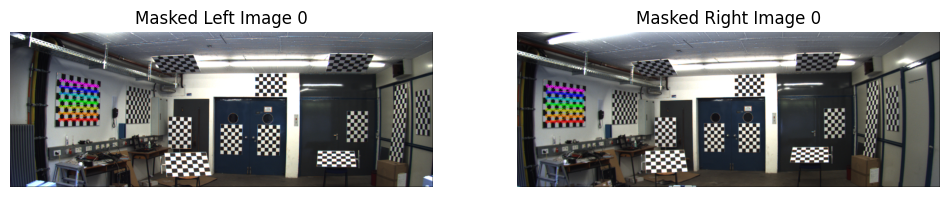

Chessboard detected with size (7, 5) in pair 1


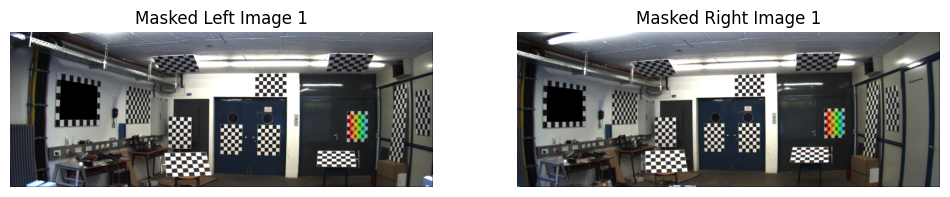

Chessboard detected with size (7, 5) in pair 2


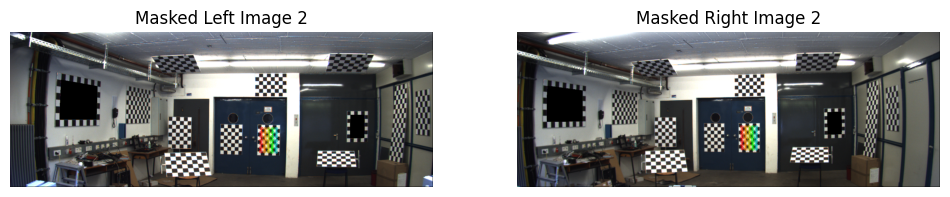

Chessboard detected with size (7, 5) in pair 3


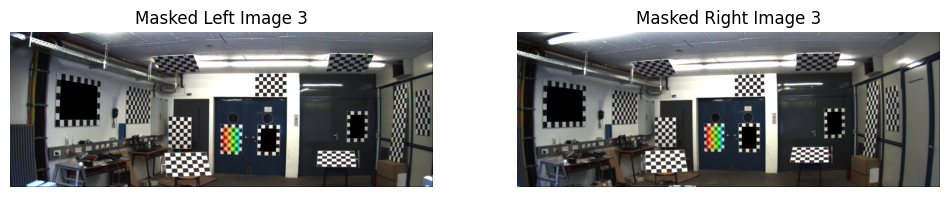

Chessboard detected with size (11, 7) in pair 4


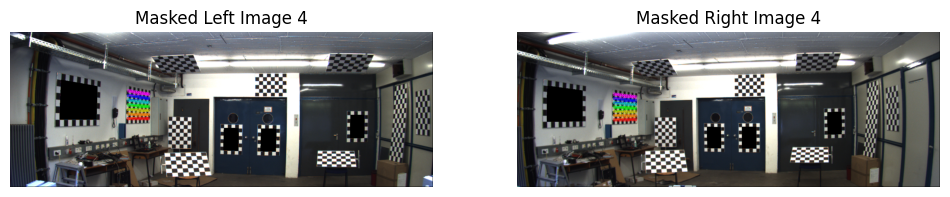

Chessboard detected with size (5, 15) in pair 5


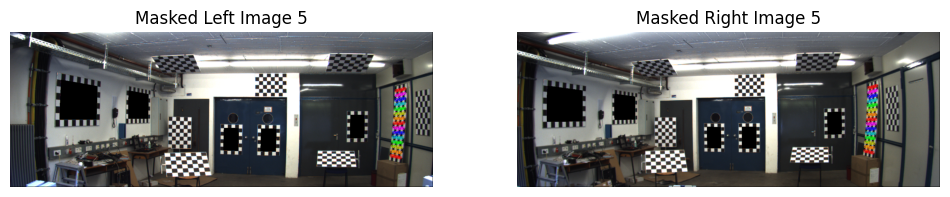

Chessboard detected with size (7, 5) in pair 6


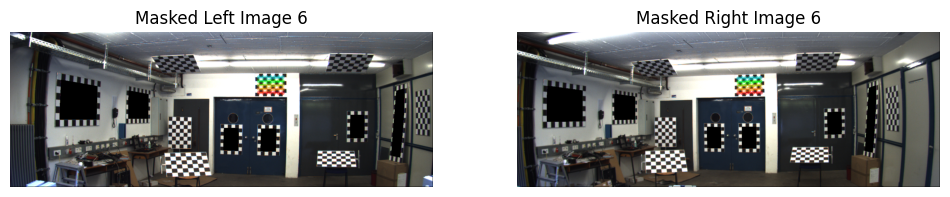

Chessboard detected with size (7, 5) in pair 7


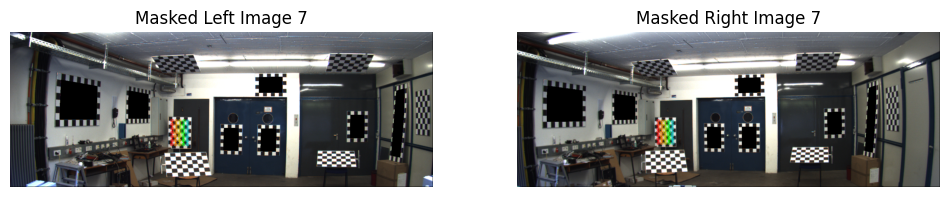

Chessboard detected with size (7, 5) in pair 8


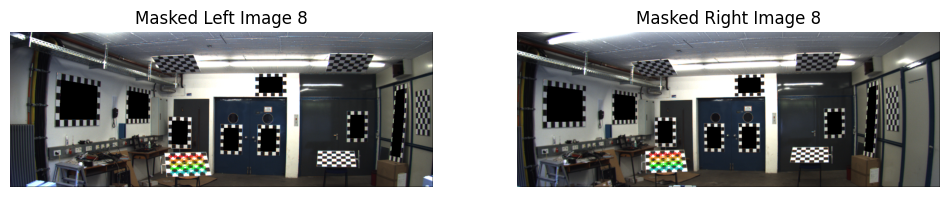

Chessboard detected with size (7, 5) in pair 9


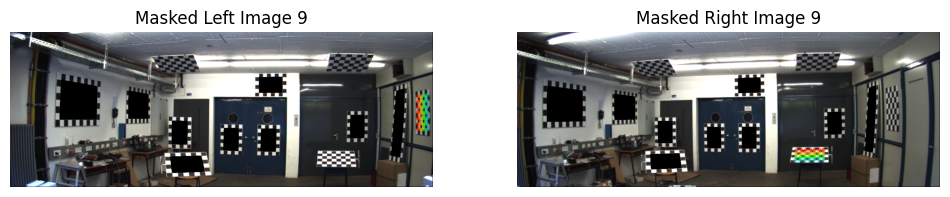

Chessboard detected with size (7, 5) in pair 10


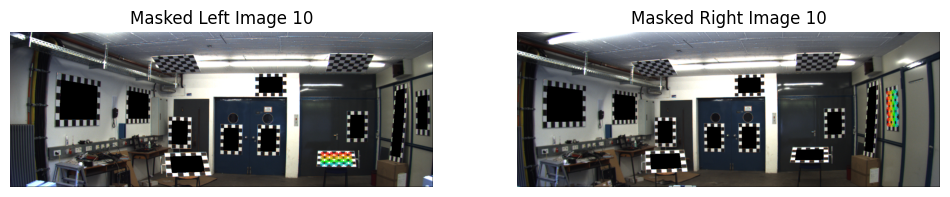

Chessboard detected with size (7, 5) in pair 11


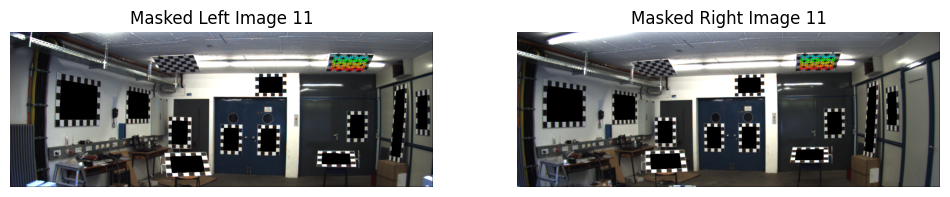

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import calib_data

# Paths to the images for the left and right cameras
left_images_path = 'image_02/data/*'
right_images_path = 'image_03/data/*'

# Chessboard patterns to check in order
chessboard_sizes = [(11, 7), (5, 15), (7, 5)]

#termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points based on the expected chessboard dimensions
def prepare_object_points(chessboard_size):
    objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    return objp

# Lists to store points for calibration
objpoints = []  # 3d points in real-world space
imgpoints_left = []  # 2d points in the left image plane
imgpoints_right = []  # 2d points in the right image plane

# Load images
left_images = sorted(glob.glob(left_images_path))
right_images = sorted(glob.glob(right_images_path))

# Function to apply mask to the image (black out detected chessboard area)
def mask_chessboards(image, imgpoints):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for corners in imgpoints:
        corners = corners.reshape(-1, 2).astype(np.int32)
        hull = cv2.convexHull(corners)
        cv2.fillConvexPoly(mask, hull, 255)
    masked_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
    return masked_image

# Process both left and right images
for i, (left_image_path, right_image_path) in enumerate(zip(left_images, right_images)):
    if i == 0:
        left_image = cv2.imread(left_image_path)
        right_image = cv2.imread(right_image_path)

    gray_left = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    # Try detecting the chessboard with different patterns in order
    detection_flags = cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY + cv2.CALIB_CB_NORMALIZE_IMAGE
    found_left = found_right = False
    chessboard_size = None

    for size in chessboard_sizes:
        found_left, corners_left = cv2.findChessboardCornersSB(gray_left, size, flags=detection_flags)
        found_right, corners_right = cv2.findChessboardCornersSB(gray_right, size, flags=detection_flags)
        
        if found_left and found_right:
            chessboard_size = size
            break

    if chessboard_size is not None and found_left and found_right:
        print(f"Chessboard detected with size {chessboard_size} in pair {i}")

        # Prepare object points for the detected chessboard size
        objp = prepare_object_points(chessboard_size)

        # Refine corner detection
        # corners_left = cv2.cornerSubPix(gray_left, corners_left, (11, 11), (-1, -1), termination_criteria)
        # corners_right = cv2.cornerSubPix(gray_right, corners_right, (11, 11), (-1, -1), termination_criteria)

        # Save object points and image points
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Draw the detected chessboard for visualization
        cv2.drawChessboardCorners(left_image, chessboard_size, corners_left, found_left)
        cv2.drawChessboardCorners(right_image, chessboard_size, corners_right, found_right)

        # Plot the masked images to visualize the detection
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Masked Left Image {i}")
        axes[0].axis('off')
        axes[1].imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Masked Right Image {i}")
        axes[1].axis('off')
        plt.show()

        # Apply mask to the next image in the folder if it exists (i+1 image)
        if i + 1 < len(left_images):
            next_left_image = cv2.imread(left_images[i + 1])
            next_right_image = cv2.imread(right_images[i + 1])

            # Mask the next image
            next_left_image = mask_chessboards(next_left_image, imgpoints_left)
            next_right_image = mask_chessboards(next_right_image, imgpoints_right)

            # Update the images to use the masked versions for next processing
            left_image = next_left_image
            right_image = next_right_image



In [2]:
h, w = left_image.shape[:2]
# Calibrate the camera with the detected points
ret, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(objpoints, imgpoints_left, (w, h), None, None)
ret, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(objpoints, imgpoints_right, (w, h), None, None)

# Perform fisheye calibration (if needed)
# Apply new camera matrix to undistort each image
newcameramtxl, roi = cv2.getOptimalNewCameraMatrix(mtxl, distl, (w, h), 1, (w, h))
newcameramtxr, roi = cv2.getOptimalNewCameraMatrix(mtxr, distr, (w, h), 1, (w, h))
flags = 0
# Stereo camera calibration
ret, K_02, D_02, K_03, D_03, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right, newcameramtxl, distl, newcameramtxr, distr,
    (w, h), flags=cv2.CALIB_USE_INTRINSIC_GUESS
)

print("Calibration completed.")
print("Camera Matrix 1:", K_02)
print("Camera distortion 1:", D_02)
print("Camera Matrix 2:", K_03)
print("Camera distortion 1:", D_03)
print("-----------------------------------------------")
print("error in percentage compared with calib_cam_to_cam.txt")
print("K_02 error", np.abs(K_02 - calib_data.K_02) / np.abs(calib_data.K_02) * 100)
print("D_02 error", np.abs(D_02 - calib_data.D_02) / np.abs(calib_data.D_02) * 100)
print("K_03 error", np.abs(K_03 - calib_data.K_03) / np.abs(calib_data.K_03) * 100)
print("D_03 error", np.abs(D_03 - calib_data.D_03) / np.abs(calib_data.D_03) * 100)


Calibration completed.
Camera Matrix 1: [[1.07041245e+03 0.00000000e+00 7.38004605e+02]
 [0.00000000e+00 9.57924567e+02 3.36391752e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Camera distortion 1: [[-0.05750586 -0.33974073 -0.09462599 -0.09861778  0.30608745]]
Camera Matrix 2: [[860.13042983   0.         706.59475461]
 [  0.         804.02859796 374.7475856 ]
 [  0.           0.           1.        ]]
Camera distortion 1: [[-0.34918955  0.14085377  0.04992241 -0.01702408 -0.04792815]]
-----------------------------------------------
error in percentage compared with calib_cam_to_cam.txt
K_02 error [[11.85696663         nan  6.34429147]
 [        nan  0.59747501 40.98086011]
 [        nan         nan  0.        ]]
D_02 error [[   84.66901309   263.58556889 21860.4788724   6251.45469359
    509.79714427]]
K_03 error [[ 4.54669164         nan  1.18861773]
 [        nan 10.37108973 57.62605248]
 [        nan         nan  0.        ]]
D_03 error [[5.26627548e+00 2.62030275e+01 8.874

/var/folders/3v/gbl9b_6d3gj0rf1x3tz1rm7r0000gn/T/ipykernel_62460/17759685.py:24: RuntimeWarning: invalid value encountered in divide
  print("K_02 error", np.abs(K_02 - calib_data.K_02) / np.abs(calib_data.K_02) * 100)
/var/folders/3v/gbl9b_6d3gj0rf1x3tz1rm7r0000gn/T/ipykernel_62460/17759685.py:26: RuntimeWarning: invalid value encountered in divide
  print("K_03 error", np.abs(K_03 - calib_data.K_03) / np.abs(calib_data.K_03) * 100)


error in percentage compared with calib_cam_to_cam.txt
P_02 error [[  36.52109376           nan   66.02019616  100.        ]
 [          nan   36.52109376 2703.77182225  100.        ]
 [          nan           nan    0.          100.        ]]
R_02 error [[2.95725876e+00 1.42812856e+03 1.34103617e+03]
 [8.88300204e+02 6.58414841e+01 7.20775876e+05]
 [3.21338534e+03 4.22632275e+05 6.34028122e+01]]
P_03 error [[3.65210938e+01            nan 6.60201962e+01 1.00000000e+02]
 [           nan 3.65210938e+01 2.70377182e+03 9.61826002e+05]
 [           nan            nan 0.00000000e+00 1.00000000e+02]]
R_03 error [[1.78039952e+00 1.73310704e+03 7.53667622e+02]
 [2.90064877e+03 5.91499476e+01 5.42588132e+04]
 [2.82544048e+02 5.13013537e+04 5.78731615e+01]]


/var/folders/3v/gbl9b_6d3gj0rf1x3tz1rm7r0000gn/T/ipykernel_62460/2990754794.py:7: RuntimeWarning: invalid value encountered in divide
  print("P_02 error", np.abs(P1 - calib_data.P_rect_02) / np.abs(calib_data.P_rect_02) * 100)
/var/folders/3v/gbl9b_6d3gj0rf1x3tz1rm7r0000gn/T/ipykernel_62460/2990754794.py:9: RuntimeWarning: invalid value encountered in divide
  print("P_03 error", np.abs(P2 - calib_data.P_rect_03) / np.abs(calib_data.P_rect_03) * 100)


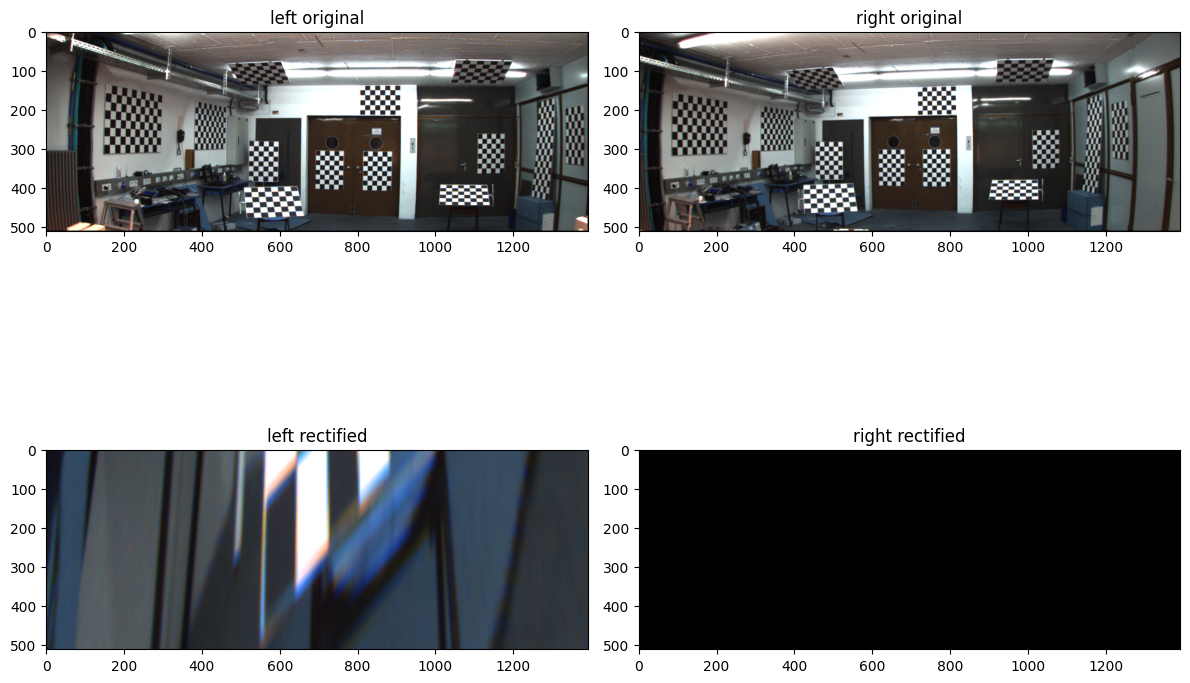

In [3]:
left_img = cv2.imread('image_02/data/0000000018.png')
right_img = cv2.imread('image_03/data/0000000018.png')

R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(K_02, D_02, K_03, D_03, (w, h), R, T)

print("error in percentage compared with calib_cam_to_cam.txt")
print("P_02 error", np.abs(P1 - calib_data.P_rect_02) / np.abs(calib_data.P_rect_02) * 100)
print("R_02 error", np.abs(R1 - calib_data.R_rect_02) / np.abs(calib_data.R_rect_02) * 100)
print("P_03 error", np.abs(P2 - calib_data.P_rect_03) / np.abs(calib_data.P_rect_03) * 100)
print("R_03 error", np.abs(R2 - calib_data.R_rect_03) / np.abs(calib_data.R_rect_03) * 100)

xmap1, ymap1 = cv2.initUndistortRectifyMap(K_02, D_02, R1, P1, (w, h), cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(K_03, D_03, R2, P2, (w, h), cv2.CV_32FC1)

left_img_rectified = cv2.remap(left_img, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(right_img, xmap2, ymap2, cv2.INTER_LINEAR)


plt.figure(0, figsize=(12,10))
plt.subplot(221)
plt.title('left original')
plt.imshow(left_img, cmap='gray')
plt.subplot(222)
plt.title('right original')
plt.imshow(right_img, cmap='gray')
plt.subplot(223)
plt.title('left rectified')
plt.imshow(left_img_rectified, cmap='gray')
plt.subplot(224)
plt.title('right rectified')
plt.imshow(right_img_rectified, cmap='gray')
plt.tight_layout()
plt.show()